# HVSR computing and plotting code

In [1]:
## ----Importing necessary stuff----
import os  # Handling filesystems
import warnings
 
# Ignoring a silly warning from HVSRPY and PANDAS
warnings.simplefilter("ignore", UserWarning) 
warnings.simplefilter("ignore", RuntimeWarning) 
warnings.simplefilter("ignore", RuntimeWarning) 

import numpy as np  # Numerical array management
import matplotlib.pyplot as plt  # Plot results
from matplotlib.collections import LineCollection
from matplotlib import spines
from tqdm import tqdm  # To track progress of HVSR computations
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
from scipy.integrate import romb, cumulative_simpson, simpson
import pandas as pd

plt.rcParams['date.converter'] = 'concise'
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

from obspy.clients.filesystem.sds import Client  # Locally stored data
from obspy import read, read_inventory, UTCDateTime  # Creating datetime objects

import hvsrpy  # Dear goodness
from hvsrpy import preprocess, process, TimeSeries, SeismicRecording3C, settings, sesame
from hvsrpy import frequency_domain_window_rejection as window_rejection

from IPython.display import clear_output

## Calculating

In [2]:
# sds = '/Users/roberto/Documents/colima-data/sds'

In [3]:
# inv = read_inventory('/Users/roberto/Documents/colima-data/response/MNGR.xml')
# for canal in inv[0][0]:
#     canal.location_code = '00'

In [4]:
# ## ----Setting up OBSPY client----
# client = Client(sds)
# net = 'UC'  # Universidad de Colima
# sta = 'MNGR'  # Montegrande
# loc = '00'
# cha = 'HH*'  # Every broadband channel

In [5]:
# st = client.get_waveforms(net, sta, loc, cha, UTCDateTime(2015,1,1), UTCDateTime(2015,1,2))
# st

In [6]:
## ----Setting up HVSRPY----
freq1 = 1
freq2 = 25
nfreqs = 200
freqs = np.geomspace(freq1,freq2,nfreqs)

# Preprocessing (detrend, window length, bandpass filter)
preproc = settings.HvsrPreProcessingSettings()  # Init 
preproc.detrend = 'linear'
preproc.window_length_in_seconds = 60  # why no overlap?
preproc.filter_corner_frequencies_in_hz = [0.1, 49.0]
print('-'*60)
print('Preprocessing Summary')
print('-'*60)
preproc.psummary()

# Processing for traditional HVSR
proc = settings.HvsrTraditionalProcessingSettings()  # Init
proc.window_type_and_width = ('tukey', 0.2)
proc.smoothing = dict(operator = 'konno_and_ohmachi',
                      bandwidth = 40,
                      center_frequencies_in_hz = freqs)
proc.method_to_combine_horizontals = 'geometric_mean'
print('-'*60)
print('Processing Summary for Traditional HVSR')
print("-"*60)
proc.psummary()

# Processing for single-azimuth HVSR (east)
proc_east = settings.HvsrTraditionalSingleAzimuthProcessingSettings()
proc_east.window_type_and_width = ('tukey', 0.2)
proc_east.smoothing = dict(operator = 'konno_and_ohmachi',
                           bandwidth = 40,
                           center_frequencies_in_hz = freqs)
proc_east.azimuth_in_degrees = 90
print('-'*60)
print('Processing Summary (East)')
print("-"*60)
proc_east.psummary()

# Window rejection
n = 2

------------------------------------------------------------
Preprocessing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0
orient_to_degrees_from_north             : 0.0
filter_corner_frequencies_in_hz          : [0.1, 49.0]
window_length_in_seconds                 : 60
detrend                                  : linear
preprocessing_method                     : hvsr
------------------------------------------------------------
Processing Summary for Traditional HVSR
------------------------------------------------------------
hvsrpy_version                           : 2.0.0
window_type_and_width                    : ('tukey', 0.2)
smoothing                                :
     operator                            : konno_and_ohmachi
     bandwidth                           : 40
     center_frequencies_in_hz            : [1.0, 1.016306783052 ... 9887153848541, 25.0]
fft_settings                             : None
handl

In [7]:
def HVSR_FULL_FROM_ST(stream,preproc,proc):
    '''
    Feed it a pre-merged Obspy Stream object
    for simplicity's sake
    '''
    # Load waveforms to HVSRPY
    source = SeismicRecording3C(
        TimeSeries(
            stream.select(component='N')[0].data,
            stream.select(component='N')[0].stats.delta
        ), 
        TimeSeries(
            stream.select(component='E')[0].data,
            stream.select(component='E')[0].stats.delta
        ), 
        TimeSeries(
            stream.select(component='Z')[0].data,
            stream.select(component='Z')[0].stats.delta
        )
    )
    srecords = preprocess(source,preproc)
    hvsr = process(srecords,proc)
    window_rejection(hvsr,n=n,search_range_in_hz=(1,20))
    
    return hvsr

In [8]:
def HVSR_EAST_FROM_ST(stream, preproc, proc):
    '''
    Feed it a pre-merged Obspy Stream object
    for simplicity's sake
    '''
    # Load waveforms to HVSRPY
    source = SeismicRecording3C(
        TimeSeries(
            stream.select(component='E')[0].data,
            stream.select(component='E')[0].stats.delta
        ),
        TimeSeries(
            stream.select(component='E')[0].data,
            stream.select(component='E')[0].stats.delta
        ),
        TimeSeries(
            stream.select(component='Z')[0].data,
            stream.select(component='Z')[0].stats.delta
        )
    )
    srecords = preprocess(source, preproc)
    hvsr = process(srecords, proc)
    window_rejection(hvsr, n=n, search_range_in_hz=(1,20))

    return hvsr

In [9]:
def datetimedayparser(utcdatetime):
    year = utcdatetime.year
    month = utcdatetime.month
    day = utcdatetime.day
    return f"{year}-{month}-{day}"

In [10]:
# ptime = UTCDateTime(2015,1,1)

# totaldays = 365

# days = []
# dates = []
# mpldates = []
# curves_full = []
# curves_east = []

# avgamps_Z = []

# peak_f0_freqs_full = []
# peak_f0_amps_full = []
# peak_f0_freqs_east = []
# peak_f0_amps_east = []

# mean_f0_freqs_full = []
# mean_f0_amps_full = []
# mean_f0_freqs_east = []  
# mean_f0_amps_east = []  


In [11]:
# for i in tqdm(range(totaldays)):
#     try:
#         stime = ptime + i * 86400
#         etime = stime + 86400
#         day_julian = i 
#         # Read waveforms
#         st = client.get_waveforms(net, sta, loc, cha, stime, etime)
#         st.merge(fill_value = 0)
#         st.remove_sensitivity(inventory=inv)
#         st.detrend('linear')
#         st.filter('highpass',freq=1)
#         ampdata = np.mean(np.abs(st.select(component='Z')[0].data))
#         # # Load waveforms to HVSRPY
#         hv_full = HVSR_FULL_FROM_ST(st,preproc,proc)
#         hv_east = HVSR_EAST_FROM_ST(st,preproc,proc)

#         curve_full = hv_full.mean_curve()
#         curves_full.append(curve_full)
#         curve_east = hv_east.mean_curve()
#         curves_east.append(curve_east)


#         days.append(day_julian)
#         dates.append(stime)
#         mpldates.append(stime.matplotlib_date)
#         avgamps_Z.append(ampdata)


#         peak_full_f, peak_full_a = hv_full.mean_curve_peak()
#         peak_east_f, peak_east_a = hv_east.mean_curve_peak()

#         peak_f0_freqs_full.append(peak_full_f)
#         peak_f0_amps_full.append(peak_full_a)
#         peak_f0_freqs_east.append(peak_east_f)
#         peak_f0_amps_east.append(peak_east_a)

#         mean_full_f = hv_full.mean_fn_frequency()
#         mean_full_a = hv_full.mean_fn_amplitude()
#         mean_east_f = hv_east.mean_fn_frequency()
#         mean_east_a = hv_east.mean_fn_amplitude()

#         mean_f0_freqs_full.append(mean_full_f)
#         mean_f0_amps_full.append(mean_full_a)
#         mean_f0_freqs_east.append(mean_east_f)
#         mean_f0_amps_east.append(mean_east_a)

#     except:
#         pass
# plotdates = np.array(dates).astype('datetime64[s]')

In [12]:
# d_hv = {'day':days,'date':dates,'mpldate':mpldates,'curves_east':curves_east,'curves_full':curves_full,
#         'peak_east_f':peak_f0_freqs_east,'peak_east_a':peak_f0_amps_east,
#         'peak_full_f':peak_f0_freqs_full,'peak_full_a':peak_f0_amps_full,
#         'mean_east_f':mean_f0_freqs_east,'mean_east_a':mean_f0_amps_east,
#         'mean_full_f':mean_f0_freqs_full,'mean_full_a':mean_f0_amps_full}

In [13]:
# df_hv = pd.DataFrame(data=d_hv)
# df_hv.to_json('hvsr_colima_24h.json')

## Plotting

In [14]:
df_hv = pd.read_json('hvsr_colima_24h.json')
df_hv.head()

,day,date,mpldate,curves_east,curves_full,peak_east_f,peak_east_a,peak_full_f,peak_full_a,mean_east_f,mean_east_a,mean_full_f,mean_full_a
0,0,"{'DEFAULT_PRECISION': 6, 'date': 1420070400000...",16436,"[1.5100664324, 1.5029417006, 1.492066539800000...","[1.416924689, 1.4064789071, 1.3933860775, 1.37...",4.084696,2.386179,4.019156,2.184369,4.594905,2.813053,4.513645,2.467677
1,1,"{'DEFAULT_PRECISION': 6, 'date': 1420156800000...",16437,"[1.4758297052, 1.4776174344, 1.478499830700000...","[1.3949869977, 1.3935612056, 1.389911868, 1.38...",5.206334,2.366513,3.954668,2.160003,4.577628,2.806220,4.574177,2.461278
2,2,"{'DEFAULT_PRECISION': 6, 'date': 1420243200000...",16438,"[1.3965152525, 1.4050583857, 1.415632597200000...","[1.3407769602, 1.340486752, 1.3419857094, 1.34...",5.291233,2.376593,5.291233,2.159272,4.616208,2.795881,4.615765,2.452763
3,3,"{'DEFAULT_PRECISION': 6, 'date': 1420329600000...",16439,"[1.5349026165000001, 1.5232253809, 1.507721110...","[1.4317200063, 1.414563465, 1.3943243511, 1.37...",4.084696,2.371169,4.019156,2.153271,4.634503,2.788605,4.573323,2.443291
4,4,"{'DEFAULT_PRECISION': 6, 'date': 1420416000000...",16440,"[1.5738498916, 1.5680575758000002, 1.556983318...","[1.4564144030000001, 1.4485902458, 1.437586092...",4.084696,2.372749,4.019156,2.151667,4.588288,2.780844,4.579575,2.437121


Explanation:
- `day`: days passed since midnight, January 1st 2015 (UTC)
- `date`: start date and time of seismic record giving an individual HVSR curve
- `mpldate`: miscellaneous, unused
- `curves_east`: daily curves for east-only HVSR
- `curves_full`: daily curves for two-component HVSR, averaged geometrically
- `peak_`: peak (in frequency and amplitude) for daily HVSR curve
- `mean_`: mean frequency and amplitude from all the HVSR curves which, when averaged, result in a daily curve

In [15]:
curves_east_pd = df_hv['curves_east']
curves_full_pd = df_hv['curves_full']
curves_east = np.zeros((len(curves_east_pd),len(freqs)))
curves_full = np.zeros((len(curves_full_pd),len(freqs)))
for i in range(len(curves_east_pd)):
   curves_east[i,:] = np.array(curves_east_pd[i])
   curves_full[i,:] = np.array(curves_full_pd[i])


In [16]:
df_hv['date'][180]  # the day before the flows were deposited

{'DEFAULT_PRECISION': 6,
 'date': 1436486400000,
 'datetime': 1436486400000,
 'day': 10,
 'hour': 0,
 'julday': 191,
 'matplotlib_date': 16626.0,
 'microsecond': 0,
 'minute': 0,
 'month': 7,
 'ns': 1436486400000000000,
 'precision': 6,
 'second': 0,
 'time': '00:00:00',
 'timestamp': 1436486400.0,
 'weekday': 4,
 'year': 2015}

In [17]:
df_hv['date'][182]  # the day after the flows were deposited

{'DEFAULT_PRECISION': 6,
 'date': 1436659200000,
 'datetime': 1436659200000,
 'day': 12,
 'hour': 0,
 'julday': 193,
 'matplotlib_date': 16628.0,
 'microsecond': 0,
 'minute': 0,
 'month': 7,
 'ns': 1436659200000000000,
 'precision': 6,
 'second': 0,
 'time': '00:00:00',
 'timestamp': 1436659200.0,
 'weekday': 6,
 'year': 2015}

In [18]:
# Separating between pre-PDC and post-PDC HVSR measurements
curves_east_pre  = curves_east[:181]
curves_east_post = curves_east[182:]
curves_full_pre  = curves_full[:181]
curves_full_post = curves_full[182:]

In [19]:
# Creating the BIG HVSR curves
hv_east_pre  = hvsrpy.HvsrTraditional(freqs, curves_east_pre)
hv_east_post = hvsrpy.HvsrTraditional(freqs, curves_east_post)
hv_full_pre  = hvsrpy.HvsrTraditional(freqs, curves_full_pre)
hv_full_post = hvsrpy.HvsrTraditional(freqs, curves_full_post)

In [20]:
window_rejection(hv_east_pre,2,50)
window_rejection(hv_east_post,2,50)
window_rejection(hv_full_pre,2,50)
window_rejection(hv_full_post,2,50)

1

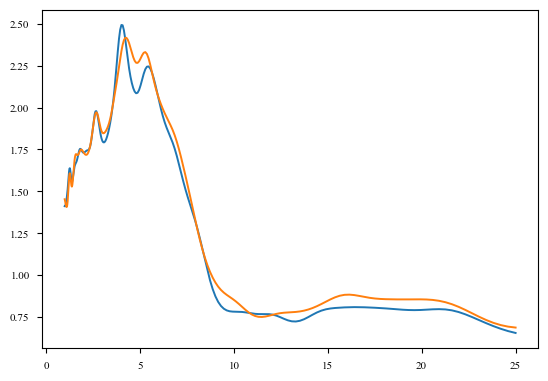

In [21]:
plt.plot(hv_east_pre.frequency,hv_east_pre.mean_curve())
plt.plot(hv_east_post.frequency,hv_east_post.mean_curve())

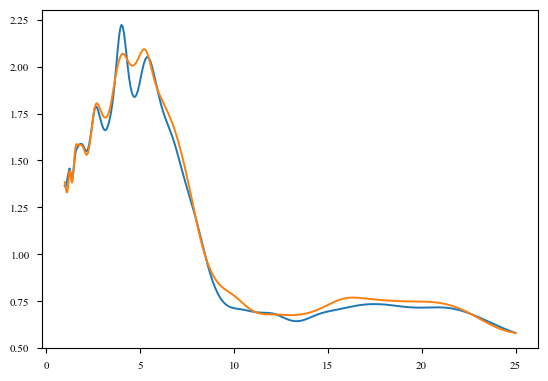

In [22]:
plt.plot(hv_full_pre.frequency,hv_full_pre.mean_curve())
plt.plot(hv_full_post.frequency,hv_full_post.mean_curve())

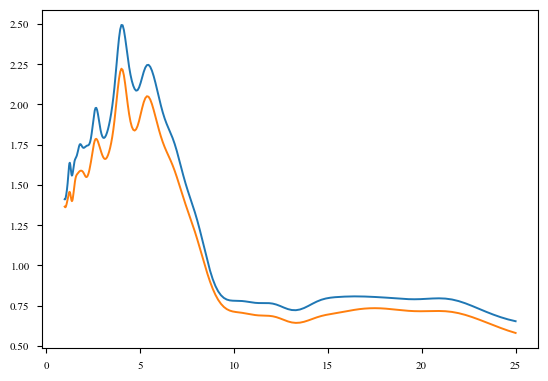

In [23]:
plt.plot(hv_east_pre.frequency,hv_east_pre.mean_curve())
plt.plot(hv_full_pre.frequency,hv_full_pre.mean_curve())

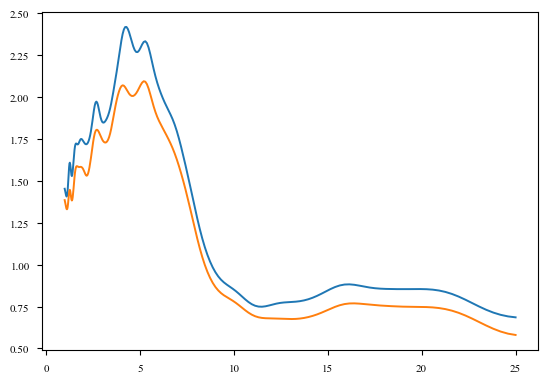

In [24]:
plt.plot(hv_east_post.frequency,hv_east_post.mean_curve())
plt.plot(hv_full_post.frequency,hv_full_post.mean_curve())

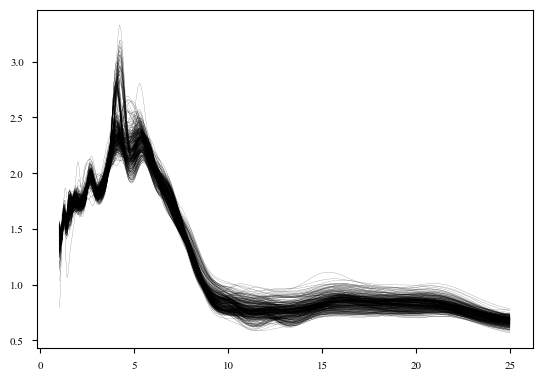

In [25]:
for i in range(curves_east[:,0].shape[0]):
    plt.plot(freqs,curves_east[i],linewidth=0.1,c='k')

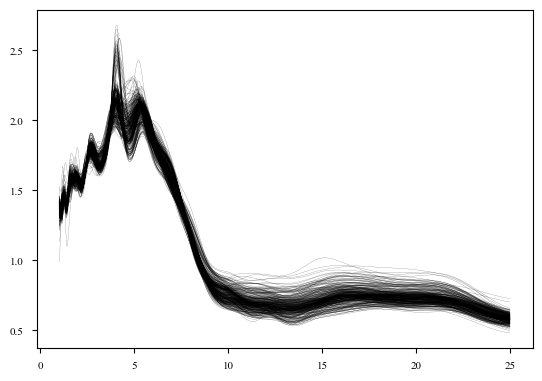

In [26]:
for i in range(curves_full[:,0].shape[0]):
    plt.plot(freqs,curves_full[i],linewidth=0.1,c='k')

(0.4, 3.4)

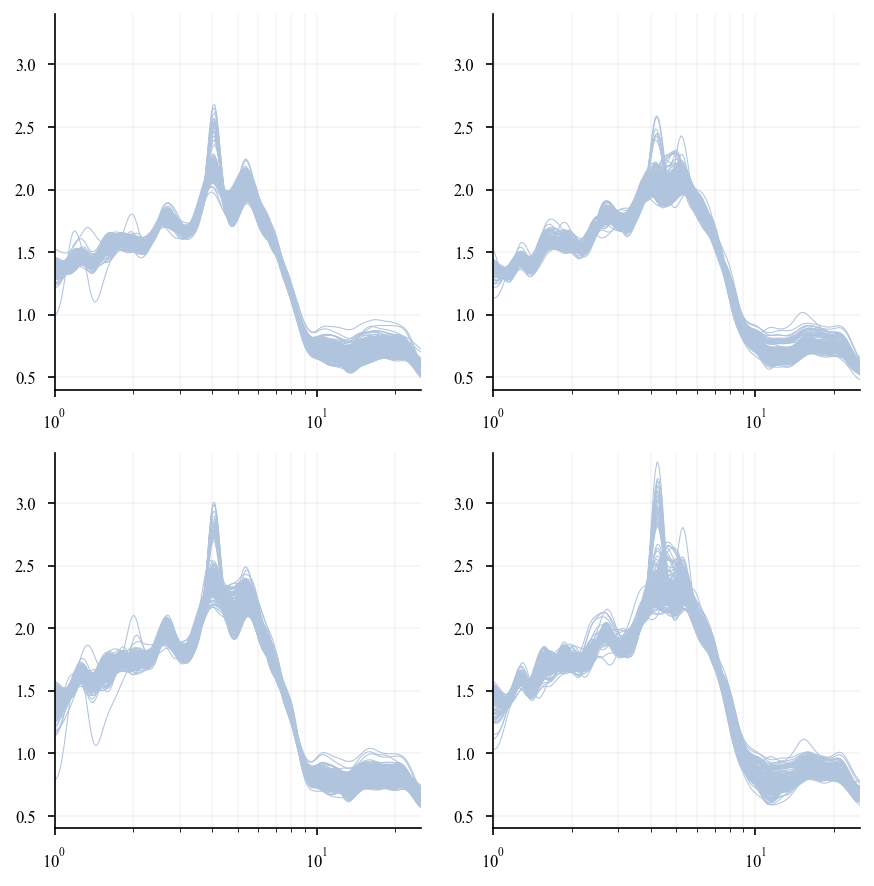

In [72]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (6,6), dpi=150)
fig.tight_layout()
# fig.subplots_adjust(hspace=0)
# Pre Full
axs[0, 0].grid(which='both',axis='both',linewidth=0.1)
for i in range(curves_full_pre[:,0].shape[0]):
    axs[0, 0].plot(freqs,curves_full_pre[i],linewidth=0.5,c='lightsteelblue')
axs[0, 0].spines[['top','right']].set_visible(False)
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlim(1,25)
axs[0, 0].set_ylim(0.4,3.4)

# Post Full
axs[0, 1].grid(which='both',axis='both',linewidth=0.1)
for i in range(curves_full_post[:,0].shape[0]):
    axs[0, 1].plot(freqs,curves_full_post[i],linewidth=0.5,c='lightsteelblue')
axs[0, 1].spines[['top','right']].set_visible(False)
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlim(1,25)
axs[0, 1].set_ylim(0.4,3.4)

# Pre East
axs[1, 0].grid(which='both',axis='both',linewidth=0.1)
for i in range(curves_east_pre[:,0].shape[0]):
    axs[1, 0].plot(freqs,curves_east_pre[i],linewidth=0.5,c='lightsteelblue')
axs[1, 0].spines[['top','right']].set_visible(False)
axs[1, 0].set_xscale('log')
axs[1, 0].set_xlim(1,25)
axs[1, 0].set_ylim(0.4,3.4)

# Post East
axs[1, 1].grid(which='both',axis='both',linewidth=0.1)
for i in range(curves_east_post[:,0].shape[0]):
    axs[1, 1].plot(freqs,curves_east_post[i],linewidth=0.5,c='lightsteelblue')
axs[1, 1].spines[['top','right']].set_visible(False)
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlim(1,25)
axs[1, 1].set_ylim(0.4,3.4)
# axs[0, 0].plot()
# for ii, flow in enumerate(specsZ):
#     # wave 
#     axs[ii, 0].plot(times[ii], 1000*waves[ii], linewidth=0.3)
#     axs[ii, 0].tick_params(direction='in', labelsize=7)
#     axs[ii, 0].spines[['top','right']].set_visible(False)
#     axs[ii, 0].set_ylim(-1.6,1.6)
#     axs[ii, 0].set_facecolor((1, 1, 1, 0))
#     # PSD mean
#     axs[ii, 1].plot(times_freqs[ii], 10*np.log10(meanampsZ[ii]), linewidth=0.3)
#     axs[ii, 1].tick_params(direction='in', labelsize=7)
#     axs[ii, 1].spines[['top','right']].set_visible(False)
#     axs[ii, 1].set_ylim(-85,-35)
#     axs[ii, 1].set_facecolor((1, 1, 1, 0))
#     # conditions
#     if ii == 2:
#         axs[ii, 0].set_ylabel('Velocity [mm/s]', fontsize=7)
#         axs[ii, 1].set_ylabel('Mean PSD [dB/Hz]', fontsize=7)
#     if ii == 5:
#         axs[ii, 0].set_xlabel('Time [s]', fontsize=7)
#         axs[ii, 1].set_xlabel('Time [s]', fontsize=7)
# fig.savefig('figura-prueba.png')

In [ ]:
curves_pre = newhvsr_pre.amplitude[newhvsr_pre.valid_window_boolean_mask]
sdmax_pre = newhvsr_pre.nth_std_curve(n=1)
sdmin_pre = newhvsr_pre.nth_std_curve(n=-1)
sdcurve_pre = np.stack([sdmax_pre,sdmin_pre])
accurves_pre = [np.column_stack([newhvsr_pre.frequency,curves_pre[i]]) for i in range(len(curves_pre))]
accoll_pre = LineCollection(accurves_pre,colors='lightsteelblue',linewidths=0.5,alpha=0.9,label='Accepted curves')
sdcurves_pre = [np.column_stack([newhvsr_pre.frequency,sdcurve_pre[i]]) for i in range(len(sdcurve_pre))]
sdcoll_pre = LineCollection(sdcurves_pre,colors='k',linestyle='dashed',label='St. Dev.')

curves_post = newhvsr_post.amplitude[newhvsr_post.valid_window_boolean_mask]
sdmax_post = newhvsr_post.nth_std_curve(n=1)
sdmin_post = newhvsr_post.nth_std_curve(n=-1)
sdcurve_post = np.stack([sdmax_post,sdmin_post])
accurves_post = [np.column_stack([newhvsr_post.frequency,curves_post[i]]) for i in range(len(curves_post))]
accoll_post = LineCollection(accurves_post,colors='lightsteelblue',linewidths=0.5,alpha=0.9,label='Accepted curves')
sdcurves_post = [np.column_stack([newhvsr_post.frequency,sdcurve_post[i]]) for i in range(len(sdcurve_post))]
sdcoll_post = LineCollection(sdcurves_post,colors='k',linestyle='dashed',label='St. Dev.')

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(16,9),dpi=300,layout='tight',facecolor='0.94')
ax1 = ax.flatten()[0]
ax1.set_title('Pre-PDCs HVSR')
ax1.grid(which='both',axis='both',linewidth=0.1)
ax1.add_collection(accoll_pre)
ax1.plot(newhvsr_pre.frequency,newhvsr_pre.mean_curve(),c='r',label='Mean curve')
ax1.add_collection(sdcoll_pre)
ax1.axvline(newhvsr_pre.mean_curve_peak()[0],c='g',linestyle='dashed',linewidth=1)
ax1.axhline(newhvsr_pre.mean_curve_peak()[1],c='g',linestyle='dashed',linewidth=1)
ax1.set_xscale('log')
ax1.set_xlim(1,50)
ax1.set_xlabel('Frequency [Hz]',fontsize=12)
ax1.set_ylabel('H/V ampltidue [-]',fontsize=12)

ax2 = ax.flatten()[1]
ax2.set_title('Post-PDCs HVSR')
ax2.grid(which='both',axis='both',linewidth=0.1)
ax2.add_collection(accoll_post)
ax2.plot(newhvsr_post.frequency,newhvsr_post.mean_curve(),c='r',label='Mean curve')
ax2.add_collection(sdcoll_post)
ax2.axvline(newhvsr_post.mean_curve_peak()[0],c='g',linestyle='dashed',linewidth=1)
ax2.axhline(newhvsr_post.mean_curve_peak()[1],c='g',linestyle='dashed',linewidth=1,label='Peak frequency')
ax2.legend(loc='upper right',fontsize=10)
ax2.set_xscale('log')
ax2.set_xlim(1,50)
ax2.set_xlabel('Frequency [Hz]',fontsize=12)
ax2.set_ylabel('H/V ampltidue [-]',fontsize=12)

ax3 = ax.flatten()[2]
ax3.grid(which='both',axis='both',linewidth=0.1)
ax3.set_title('Mean HVSR curves')
ax3.plot(newhvsr_pre.frequency,newhvsr_pre.mean_curve(),c='b')
ax3.plot(newhvsr_post.frequency,newhvsr_post.mean_curve(),c='r')
ax3.text(8,2.25,
         f'Pre-PDCs peak at f={round(newhvsr_pre.mean_curve_peak()[0],3)} Hz and A={round(newhvsr_pre.mean_curve_peak()[1],3)}',
         va='bottom')
ax3.text(8,2.25,
         f'Post-PDCs peak at f={round(newhvsr_post.mean_curve_peak()[0],3)} Hz and A={round(newhvsr_post.mean_curve_peak()[1],3)}',
         va='top')
ax3.set_xscale('log')
ax3.set_xlim(1,50)
ax3.set_xlabel('Frequency [Hz]',fontsize=12)
ax3.set_ylabel('H/V ampltidue [-]',fontsize=12)

ax4 = ax.flatten()[3]
ax4.grid(which='both',axis='both',linewidth=0.1)
ax4.set_title('Frequency density kernels')
ax4.plot(kernels['fpre'],kernels['dpre'],c='b',label='Pre-PDCs')
ax4.plot(kernels['fpost'],kernels['dpost'],c='r',label='Post-PDCs')
ax4.axvline(pre_avg,linestyle='dashed',linewidth=1,c='b',label='mean')
ax4.axvline(post_avg,linestyle='dashed',linewidth=1,c='r')
ax4.text(2.5,1.75,
         f'Mean pre-PDCs={round(pre_avg,3)} Hz\nMean post-PDCs={round(post_avg,3)} Hz',va='top')
ax4.text(2.5,1.5,
         f'Wilcoxon two-sided test:\n    Statistic: 10444\n    p-value: {np.format_float_scientific(1.345453e-07)}',va='top')
ax4.legend(fontsize=10)
ax4.set_xlabel('Frequency [Hz]')
ax4.set_ylabel('Density')


In [31]:
hvsrpy.summarize_hvsr_statistics(hv_full_post)

,Exponentitated Lognormal Median (units),Lognormal Standard Deviation (log units),-1 Lognormal Standard Deviation (units),+1 Lognormal Standard Deviation (units)
"Resonant Site Frequency, fn (Hz)",4.845,0.112,4.331,5.422
"Resonant Site Period, Tn (s)",0.206,0.112,0.231,0.184
"Resonance Amplitude, An",2.142,0.048,2.042,2.247


In [35]:
def sesame_reliability(hvsr, search_range, verbose):
    criteria_rel = hvsrpy.sesame.reliability(
        windowlength=preproc.window_length_in_seconds,
        passing_window_count=np.sum(hvsr.valid_window_boolean_mask),
        frequency=hvsr.frequency,
        mean_curve=hvsr.mean_curve(distribution="lognormal"),
        std_curve=hvsr.std_curve(distribution="lognormal"),
        search_range_in_hz=search_range,
        verbose=verbose,
    )

    print(criteria_rel)

In [48]:
def sesame_clarity(hvsr, search_range, verbose):
    criteria_cla = hvsrpy.sesame.clarity(
        frequency=hvsr.frequency,
        mean_curve=hvsr.mean_curve(distribution="lognormal"),
        std_curve=hvsr.std_curve(distribution="lognormal"),
        fn_std=hvsr.std_fn_frequency(distribution="normal"),
        search_range_in_hz=search_range,
        verbose=verbose,
    )

    print(criteria_cla)

All peaks are reliable

However, only 
f_0
f_1 peak has enough clarity only for hv_east_pre and hv_full_pre


In [57]:
sesame_clarity(hv_full_post,(1,25),1)

Assessing SESAME (2004) clarity criteria ... 
Considering only frequencies between 1.000 and 25.000 Hz.
  Criteria i): Fail
  Criteria ii): Pass
  Criteria iii): Pass
  Criteria iv): Fail
  Criteria v): Fail
  Criteria vi): Pass
  The chosen peak FAILS the peak clarity criteria, with 3 of 6.
[0. 1. 1. 0. 0. 1.]


In [ ]:
criteria_rel = hvsrpy.sesame.reliability(
    windowlength=preproc.window_length_in_seconds,
    passing_window_count=np.sum(hv_.valid_window_boolean_mask),
    frequency=hvsr.frequency,
    mean_curve=hvsr.mean_curve(distribution="lognormal"),
    std_curve=hvsr.std_curve(distribution="lognormal"),
    search_range_in_hz=search_range,
    verbose=verbose,
)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (190/25.4,6), dpi=1000)
fig.tight_layout()
fig.subplots_adjust(hspace=0)
# Pre
axs[0, 0].plot()
# for ii, flow in enumerate(specsZ):
#     # wave 
#     axs[ii, 0].plot(times[ii], 1000*waves[ii], linewidth=0.3)
#     axs[ii, 0].tick_params(direction='in', labelsize=7)
#     axs[ii, 0].spines[['top','right']].set_visible(False)
#     axs[ii, 0].set_ylim(-1.6,1.6)
#     axs[ii, 0].set_facecolor((1, 1, 1, 0))
#     # PSD mean
#     axs[ii, 1].plot(times_freqs[ii], 10*np.log10(meanampsZ[ii]), linewidth=0.3)
#     axs[ii, 1].tick_params(direction='in', labelsize=7)
#     axs[ii, 1].spines[['top','right']].set_visible(False)
#     axs[ii, 1].set_ylim(-85,-35)
#     axs[ii, 1].set_facecolor((1, 1, 1, 0))
#     # conditions
#     if ii == 2:
#         axs[ii, 0].set_ylabel('Velocity [mm/s]', fontsize=7)
#         axs[ii, 1].set_ylabel('Mean PSD [dB/Hz]', fontsize=7)
#     if ii == 5:
#         axs[ii, 0].set_xlabel('Time [s]', fontsize=7)
#         axs[ii, 1].set_xlabel('Time [s]', fontsize=7)
# fig.savefig('figura-prueba.png')
